In [2]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [3]:
import sys
sys.path.insert(0,'python')
from LS_optimizing import *
from Dload_Finder import *
import pylab as plt
%matplotlib inline
from linear_plot7 import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import partial
import multiprocessing
from fft_helper import *

In [28]:
from nicer_plot import *
plot_config()

In [ ]:
def Land_PSF_optimization(year, doy, lat, lon):
    h,v = mtile_cal(lat, lon)
    pr=get_wrs(lat, lon)
    path, row = pr[0]['path'],pr[0]['row']
    Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))
    
    
    Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, doy)
    #Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]
    Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,i,h,v))[0] for i in range(doy-8, doy+8)]
    
    if read_meta(Hfile)==None:  
        print 'Too much cloud!!'
    else:
        sza, saa, vza, vaa, dic, corners = read_meta(Hfile)
        L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)
        
        tems = np.zeros((3,6))
        tems[0,:] = sza
        tems[1,:] = vza
        tems[2,:] = vaa - saa
        
        
        for Lfile in Lfiles
            val_ins, val_brdf = get_brdf_six(Lfile,(tems[0][-2:], tems[1][-2:], tems[2][-2:]), flag=1, Linds= L_inds)
               
    
    
        
        

        
        
        
retval0=0,0.2
for xstd0 in range(-30,30,15):
    for ystd0 in range(-30,30,15):
        p0 = np.array([xstd0, ystd0])
        retval = optimize.fmin(cost,p0,full_output=1)
        if retval[1]<retval0[1]:
            retval0=retval



            
            
def cost(shifts):
    xs, ys = shifts 
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals =L_data[Lx[val], Ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(~Lvals.mask)&(qa_mask[Lx[val], Ly[val]])
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    print xs, ys
    return abs(1-r.rvalue)

In [3]:
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))

In [4]:
doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doy = doys[1]; Hsat = 'L'

Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, doy)
Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]

In [5]:
def read_meta(Hfile):
    
    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if 'CLOUD_COVER ' in line:
                cloud_cover =  float(line.split('= ')[1])
    if cloud_cover<20:
        print 'Less than 20% cloud.'
        b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
        corners = b1.shape
        dic = {}
        with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif 'ROLL_ANGLE' in line:
                    vza = float(line.split(' = ')[1])
                elif 'SUN_AZIMUTH' in line:
                    saa = float(line.split(' = ')[1])
                elif 'SUN_ELEVATION' in line:
                    sza = float(line.split(' = ')[1])
        with open('Landsat_azm.pkl', 'r') as savefile:
            Landsat_azm = pkl.load(savefile)

        vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
        
        return sza, saa, vza, vaa, dic, corners
    else:
        print 'To much cloud: ', cloud_cover
        return None  

In [6]:
sza, saa, vza, vaa, dic, corners = read_meta(Hfile)

Less than 20% cloud.


In [7]:
L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)

In [8]:
tems = np.zeros((3,6))
tems[0,:] = sza
tems[1,:] = vza
tems[2,:] = vaa-saa
brdfs, qa = get_brdf_six(Lfile, (tems[0], tems[1], tems[2]), bands=[3,4,1,2,6,7])

In [9]:
Lx, Ly = L_inds
Hx, Hy = H_inds
L_inds, H_inds

((array([354, 354, 354, ..., 864, 864, 864]),
  array([ 188,  189,  190, ..., 1316, 1317, 1318])),
 array([[  10,   10,   10, ..., 7842, 7842, 7842],
        [   1,   17,   32, ..., 7655, 7671, 7686]]))

In [10]:
cloud = gdal.Open(Hfile[:-4]+'_cfmask.tif').ReadAsArray()
cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

7


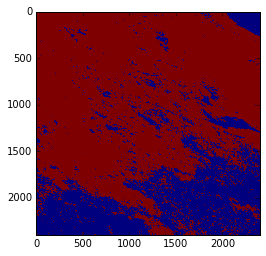

In [11]:
ind=5
B_num = L_bands[ind]
print B_num
H_data = gdal.Open(Hfile+'band%d.tif'%B_num).ReadAsArray()*0.0001
mask = ~(H_data<0).astype('bool')
small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
val_mask = (~dia_cloud)&small_mask
L_data = brdfs[ind]
qa_masks = qa<2
qa_mask = qa_masks[ind]
plt.imshow(qa_masks[0])

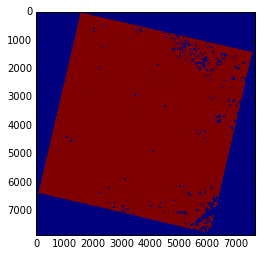

In [12]:
plt.imshow(val_mask)

In [13]:
def gaussian(xstd, ystd, angle, norm = True):
    win = int(round(max(3*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus    

In [14]:
def cost(para):
    xs, ys = 32.69694328,  4.44815254
    xstd,ystd,angle = para 
    G = gaussian(xstd,ystd,angle,True)                              
    ss = signal.fftconvolve(H_data, G, mode='same')
    # remove the cloud pixel
    ss[~val_mask]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals =L_data[Lx[val], Ly[val]]*0.001, ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(~Lvals.mask)&(qa_mask[Lx[val], Ly[val]])
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    costs = abs(1-r.rvalue)
    return para + (costs,) 

In [ ]:
pars = np.mgrid[1:50:1, 1:50:1, 0:25:1]
pars[0].flatten(), pars[1].flatten(), pars[2].flatten()
paras = zip(pars[0].flatten(), pars[1].flatten(), pars[2].flatten())

In [ ]:
pool = multiprocessing.Pool(processes = 32)
retval = pool.map(cost, paras)
pool.close()
pool.join()

In [ ]:
parallel_rw_pkl(np.array(retval), 'Second_cost_func', 'w')

In [4]:
retval = parallel_rw_pkl(None, 'Second_cost_func', 'r')

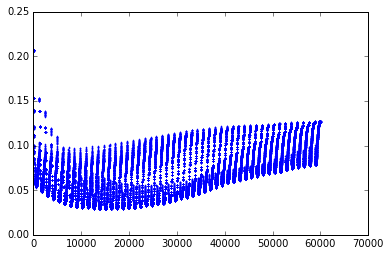

In [5]:
plt.plot(np.array(retval)[:,3], '+', markersize=2)

In [36]:
retval = np.array(retval)

In [6]:
retval[retval[:,3]==0.029194300237908588]

array([[ 13.       ,  15.       ,   0.       ,   0.0291943]])

In [7]:
stds = retval[retval[:,2]==0.]

In [8]:
stds[:,0], stds[:,1], stds[:,3]

(array([  1.,   1.,   1., ...,  49.,  49.,  49.]),
 array([  1.,   2.,   3., ...,  47.,  48.,  49.]),
 array([ 0.20524453,  0.15347313,  0.13916146, ...,  0.12688976,
         0.12718602,  0.12716105]))

In [9]:
error_surface = np.zeros((50,50))
error_surface[:] = np.nan

In [10]:
error_surface[stds[:,0].astype(int),stds[:,1].astype(int)] = stds[:,3]

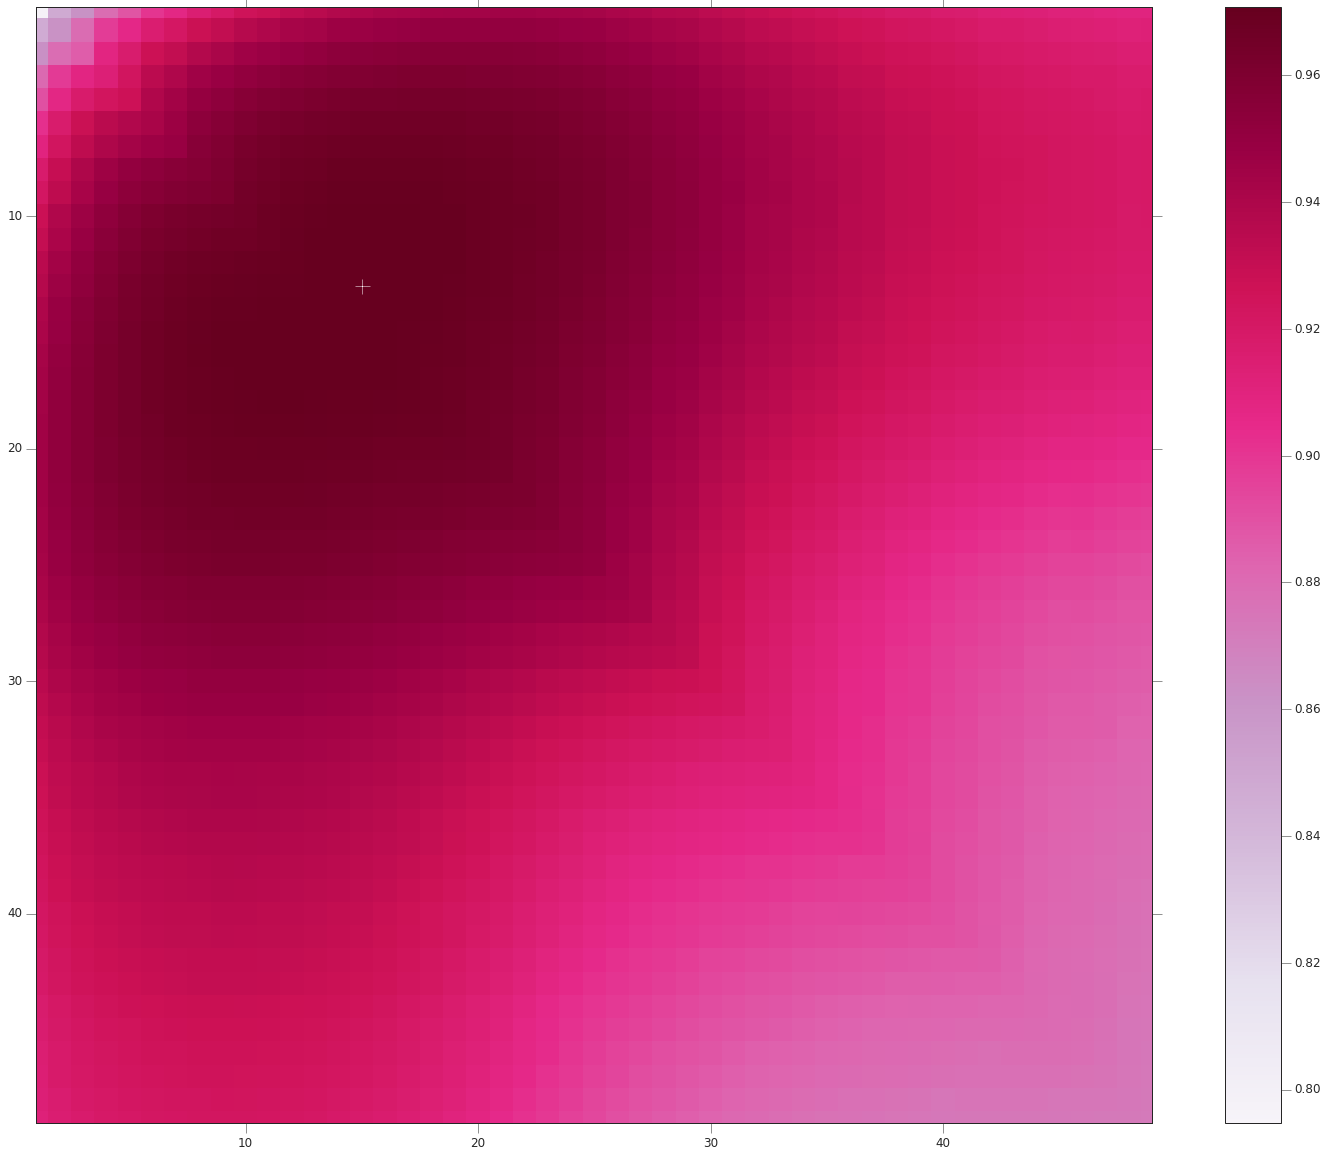

In [84]:
plt.figure(figsize=(26,20))
plt.imshow(1-error_surface, interpolation = 'None', cmap=plt.cm.get_cmap('PuRd'))
plt.xlim(1,49)
plt.ylim(49,1)
plt.plot(15,13, 'w+', markersize=15)
plt.colorbar()
plt.savefig('image/errorsurface.pdf', pdi=400)

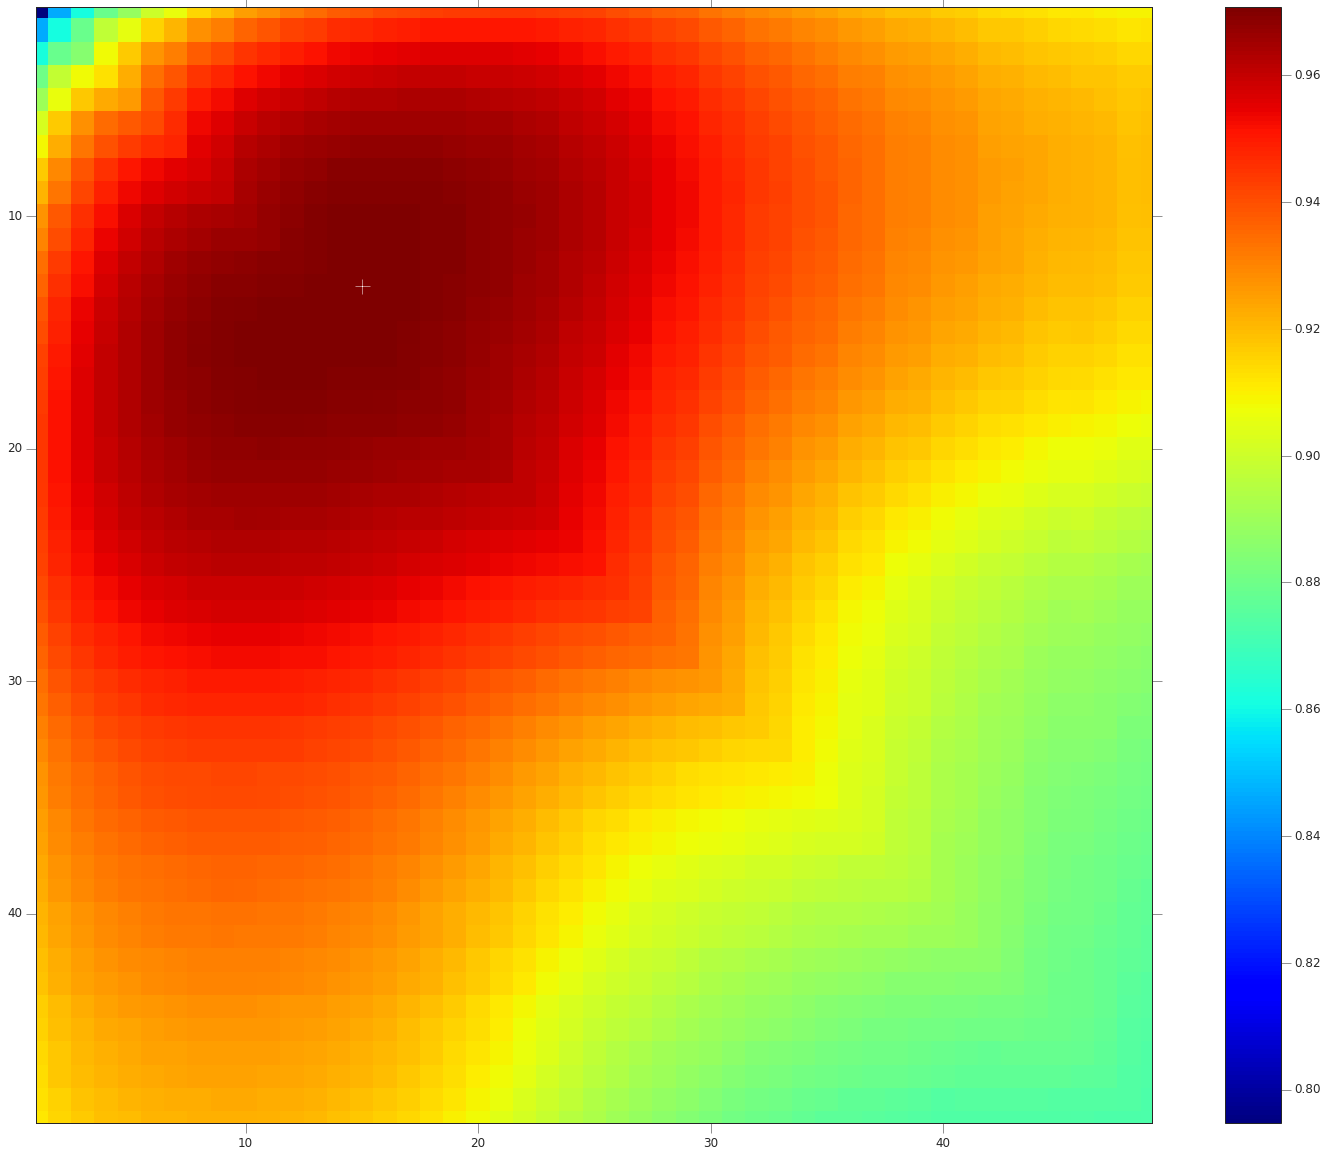

In [86]:
plt.figure(figsize=(26,20))
plt.imshow(1-error_surface, interpolation = 'None', cmap=plt.cm.get_cmap('jet'))
plt.xlim(1,49)
plt.ylim(49,1)
plt.plot(15,13, 'w+', markersize=15)
plt.colorbar()
plt.savefig('image/jet_err_sur.pdf', pdi=400)

In [123]:
x =  y = range(0,50)
x,y = np.meshgrid(x,y)

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

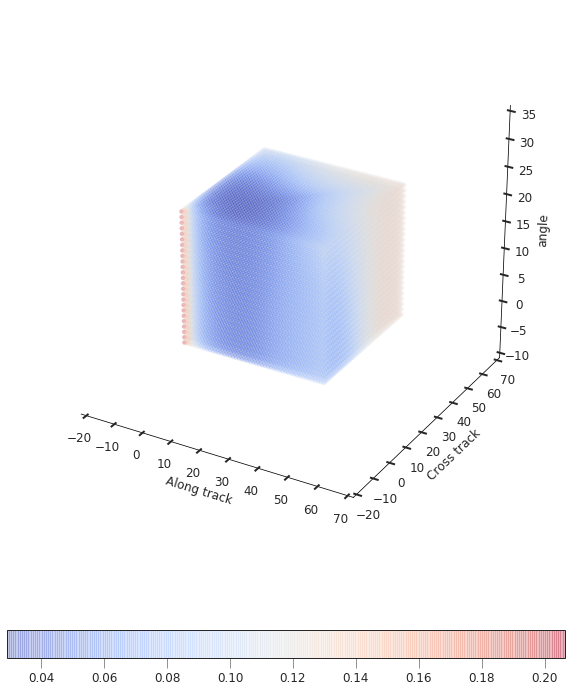

In [144]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.xaxis._axinfo['label']['space_factor'] = 2.8

sp = ax.scatter(retval[:,0],retval[:,1],retval[:,2], s=20, c=retval[:,3], alpha = 0.3, cmap=plt.cm.get_cmap('coolwarm'))
ax.set_xlabel('Along track')
ax.set_xlim(-20, 70)
ax.set_ylabel('Cross track')
ax.set_ylim(-20, 70)
ax.set_zlabel('angle')
ax.set_zlim(-10, 35)

plt.colorbar(sp, orientation="horizontal",fraction=0.07)